## SuperVAD training

Training notebook for SuperVAD

In [1]:
# Core
from typing import Optional, Union
import os
import json
import math
import random
import time
import IPython
from tqdm import tqdm

# Hacks to make DP work on consumer GPU
# os.environ["NCCL_SOCKET_IFNAME"] = "lo"
os.environ["NCCL_P2P_DISABLE"] = "1"

# ML
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch import Tensor, nn
import torch.optim as optim
from torch.profiler import profile, record_function, ProfilerActivity
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.profiler import profile, record_function, ProfilerActivity
from contextlib import nullcontext

# Audio
import torchaudio

# Local
from datasets import preprocessed_audio_dataset
# from tinyagi.utils import load_audio, spectogram, sliding_window, N_FFT, HOP_LENGTH, N_MELS, SAMPLE_RATE, N_SAMPLES, N_SAMPLES_PER_TOKEN, FRAMES_PER_SECOND, TOKENS_PER_SECOND, mel_filters
# from tinyagi.datasets import preprocessed_audio_dataset, sample_dataset, one_of, maybe, sequental

In [2]:
# WAD parameters
VAD_TOKENS = 10 # Context size
VAD_DURATION = VAD_TOKENS * 20 # 10 * 20ms = 200ms of audio
VAD_FRAMES = VAD_TOKENS * 2 # Two frame per token padding

# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu' # Could have specific device
device_type = 'cuda' if 'cuda' in device else 'cpu'
enable_autocast = True
enable_anomaly_detection = False
parallel = False
compile = True

# Precision
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float32' # Using float32 since float16 sometimes not that stable
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
autocast = nullcontext() if device_type == 'cpu' or not enable_autocast else torch.amp.autocast(device_type=device_type, dtype=ptdtype)
torch.set_float32_matmul_precision('high')

# Stats
experiment = "vad_release"
writer = SummaryWriter(f'runs/{experiment}')

In [9]:
dataset_train = preprocessed_audio_dataset('./datasets/supervad-1/vad_train')
dataset_test = preprocessed_audio_dataset('./datasets/supervad-1/vad_test')

FileNotFoundError: [Errno 2] No such file or directory: './datasets/supervad-1/vad_train/meta.json'

/home/steve/miniconda3/envs/jupyter/lib/python3.11/site-packages/torch/functional.py:650: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449201450/work/aten/src/ATen/native/SpectralOps.cpp:863.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


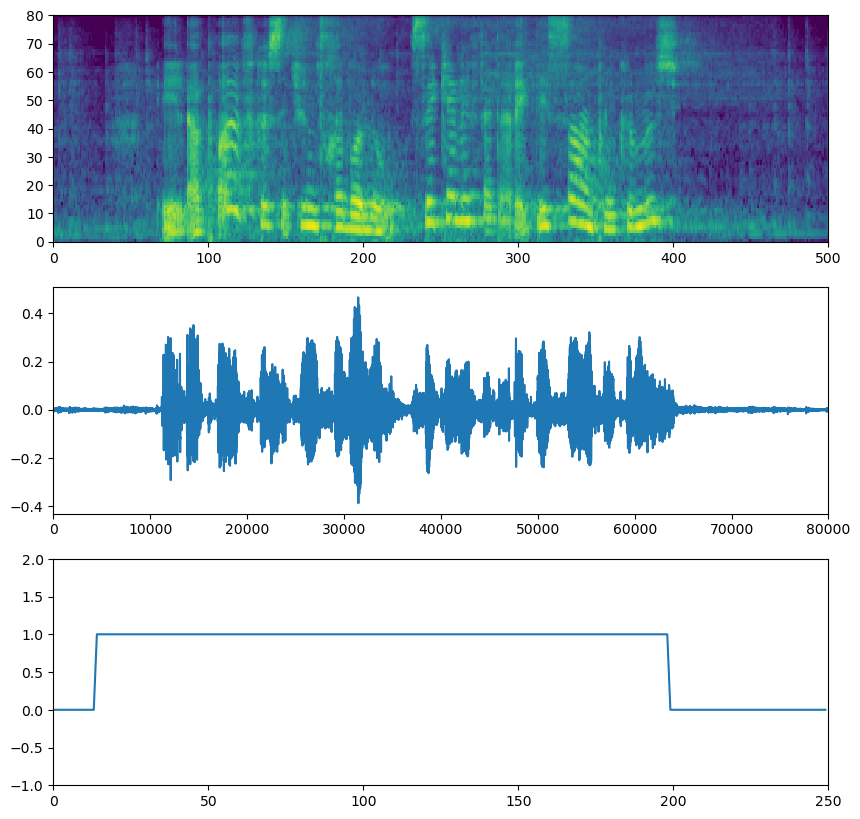

In [3]:
value, key = sample_dataset(synthetic)
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10,10))
ax1.pcolormesh(spectogram(value.unsqueeze(0))[0])
ax2.plot(value)
ax3.plot(key)
ax2.set_xlim([0, 80000])
ax3.set_ylim([-1, 2])
ax3.set_xlim([0, 250])
IPython.display.Audio(value, rate=16000)

In [4]:
# Whisper
# base = 512
# small = 768
# medium = 1024
# encoder = load_whisper(WAD_TOKENS, name="tiny", load=True)
# encoder.to(device)

class Config():
    def __init__(self):
        self.ctx_length = WAD_TOKENS
        self.ctx_width = 80 # Number of spectograms
        
        self.attn_heads = 6
        self.attn_layers = 4

        # Whisper values
        # tiny = 384
        # base = 512
        # small = 768
        # medium = 1024
        self.attn_features = 384

        # Internals
        self.bias = False
        self.dropout = 0.1
        

#
# sin embeddings precomputed
#

def embeddings(total_length, offset, length, channels, max_timescale=10000):
    assert channels % 2 == 0    
    log_timescale_increment = np.log(max_timescale) / (channels // 2 - 1)
    inv_timescales = torch.exp(-log_timescale_increment * torch.arange(channels // 2))
    scaled_time = torch.arange(total_length)[:, np.newaxis] * inv_timescales[np.newaxis, :]
    return torch.cat([torch.sin(scaled_time), torch.cos(scaled_time)], dim=1)

#
# Multi-head attention
#

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Query/Key/Value in single tensor for speedup
        self.attention = nn.Linear(config.attn_features, 3 * config.attn_features, bias=config.bias)

        # Output 
        self.output = nn.Linear(config.attn_features, config.attn_features, bias=config.bias)

        # Dropouts
        self.attention_dropout = nn.Dropout(config.dropout)
        self.output_dropout = nn.Dropout(config.dropout)
    

    def forward(self, x: Tensor):
        B, T, C = x.size() # batch size, sequence length, context width

        # Calculate Query, Key and Value
        q, k, v  = self.attention(x).split(self.config.attn_features, dim=2)
        k = k.view(B, T, self.config.attn_heads, C // self.config.attn_heads).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.config.attn_heads, C // self.config.attn_heads).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.config.attn_heads, C // self.config.attn_heads).transpose(1, 2) # (B, nh, T, hs)

        # Dot product attention
        y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.config.dropout if self.training else 0, is_causal=True)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # Output
        y = self.output_dropout(self.output(y))
        
        return y


class AttentionBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Attention
        self.attention_ln = nn.LayerNorm(config.attn_features, bias=config.bias)
        self.attention = MultiHeadAttention(config)

        # MLP
        self.mlp_ln = nn.LayerNorm(config.attn_features, bias=config.bias)
        self.mlp = nn.Sequential(
            nn.Linear(config.attn_features, config.attn_features * 4, bias=config.bias), 
            nn.GELU(), 
            nn.Linear(config.attn_features * 4, config.attn_features, bias=config.bias),
            nn.Dropout(config.dropout)
        )

    def forward(self, x: Tensor):
        x = x + self.attention(self.attention_ln(x))
        x = x + self.mlp(self.mlp_ln(x))
        return x


# WAD
class WAD(nn.Module):
    def __init__(self, config):
        super().__init__()

        # Pre-compute positional embeddings
        self.register_buffer("positional_embedding", embeddings(config.ctx_length, 0, config.ctx_length, config.attn_features))

        # Convolutions
        self.conv1 = nn.Conv1d(config.ctx_width, config.attn_features, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(config.attn_features, config.attn_features, kernel_size=3, stride=2, padding=1)
        self.conv_dropout = nn.Dropout(config.dropout)

        # Self Attention
        self.blocks_ln = nn.LayerNorm(config.attn_features, bias=config.bias)
        self.blocks: Iterable[ResidualAttentionBlock] = nn.ModuleList(
            [AttentionBlock(config) for _ in range(config.attn_layers)]
        )

        # Probability
        self.output = nn.Linear(config.ctx_length * config.attn_features, 1, bias=False)
        self.activation = torch.nn.Sigmoid()
        
    def forward(self, x):

        # Convolutions
        y = F.gelu(self.conv1(x))
        y = F.gelu(self.conv2(y))
        y = y.permute(0, 2, 1) # LogMel has (batch, mels, ctx) instead of (batch, ctx, mels). But why not to do so before convolutions?

        # Apply positional embedding
        y = (y + self.positional_embedding)

        # Dropout
        y = self.conv_dropout(y)

        # Attention
        for block in self.blocks:
            y = block(y)
        y = self.blocks_ln(y)
        
        # Flatten features
        y = torch.flatten(y, start_dim=1)

        # Regression
        y = self.output(y)
        y = F.gelu(y)

        # Return probability
        return y

# Model
base = WAD(Config())
wad = base
if compile:
    wad = torch.compile(wad)
if parallel:
    wad = nn.DataParallel(wad)
optimizer = optim.Adam(wad.parameters(), lr=0.00001)
epoch = 0
wad.to(device)

# Save/Load
def save():
    torch.save({ 'model_state_dict': base.state_dict(), 'optimizer_state_dict': optimizer.state_dict(),'epoch': epoch},  f'./checkpoints/{experiment}.pt')
    torch.save({ 'model_state_dict': base.state_dict(), 'optimizer_state_dict': optimizer.state_dict(),'epoch': epoch},  f'./checkpoints/{experiment}_{epoch}.pt')
    
def load():
    global epoch
    if os.path.isfile(f'./checkpoints/{experiment}.pt'):
        checkpoint = torch.load(f'./checkpoints/{experiment}.pt')
        base.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        return True
    return False

# Do load
load()

True

Process ForkProcess-16:
Process ForkProcess-31:
Process ForkProcess-11:
Process ForkProcess-2:
Process ForkProcess-25:
Process ForkProcess-26:
Process ForkProcess-3:
Process ForkProcess-1:
Process ForkProcess-17:
Process ForkProcess-12:
Process ForkProcess-10:
Process ForkProcess-23:
Process ForkProcess-19:
Process ForkProcess-20:
Process ForkProcess-32:
Process ForkProcess-28:
Process ForkProcess-15:
Process ForkProcess-29:
Process ForkProcess-14:
Traceback (most recent call last):
Process ForkProcess-18:
Process ForkProcess-24:
Traceback (most recent call last):
Process ForkProcess-8:
Process ForkProcess-7:
Process ForkProcess-4:
Process ForkProcess-22:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkProcess-21:
Process ForkProcess-9:
Process ForkProcess-5:
Traceback (most recent call last):
  File "/home/steve/miniconda3/envs/jupyter/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/steve/miniconda3/env

In [5]:
sampler = torch.utils.data.RandomSampler(
                    all_train, 
                    replacement=True, 
                    num_samples=100000)
loader = DataLoader(all_train, 
                    batch_size=16,
                    num_workers=8,
                    sampler=sampler,
                    pin_memory=True)

def prepare_labels(labels):    

    # Sliding window
    with record_function("batch:prepare:labels:transfer"):
        labels = labels.to(device, non_blocking=True)
    with record_function("batch:prepare:labels:window"):
        labels = sliding_window(labels, WAD_TOKENS, 1)

    # Use the last element in each window as target (we want to predict current token, not anything else)
    with record_function("batch:prepare:labels:reshape"):
        A, B, C = labels.shape
        labels = labels.reshape(A * B, C)
        # labels = torch.mean(labels, dim = 1)    # Average labels over each window
        labels = labels[..., -1] # Get last value
        labels = labels.reshape(labels.shape[0], 1) # To suppress warnings
    
    return labels

def prepare_samples(samples):

    # Spectogram
    with record_function("batch:prepare:samples:spectogram"):
        samples = spectogram(samples)
    with record_function("batch:prepare:samples:transfer"):
        samples = samples.to(device, non_blocking=True)
    # samples = samples.half() # After spectogram to reduce amount memory copy needed

    # Sliding window
    samples = sliding_window(samples, WAD_FRAMES, 2)

    # Reshape sliding window to batch
    A, B, C, D = samples.shape
    samples = samples.reshape(A * B, C, D)
    return samples

def train_batch(samples, labels):

    # Prepare
    with record_function("batch:prepare:labels"):
        labels = prepare_labels(labels)
    with record_function("batch:prepare:samples"):
        samples = prepare_samples(samples)
    
    # Train
    with torch.autograd.detect_anomaly() if enable_anomaly_detection else nullcontext():
        optimizer.zero_grad()
        with autocast:
            prediction = wad(samples)
        loss = F.mse_loss(labels, prediction.float())
        loss.backward()
        optimizer.step()

    # Stats
    return loss.detach(), labels.shape[0]

# Train single batch
s, l = next(iter(loader))
print(s.shape, l.shape)
train_batch(s, l)

torch.Size([16, 80000]) torch.Size([16, 250])


(tensor(0.1958, device='cuda:0'), 3856)

In [6]:
def validate():
    wad.eval()
    ls = 0.0
    with torch.no_grad():

        # Sample
        with record_function("sample"):
            random.seed(42)
            samples, labels = [], []
            for i in range(0, 10):
                s, l = sample_dataset(libri_eval)
                samples.append(s)
                labels.append(l)
            random.seed(None)
            samples = torch.stack(samples)
            labels = torch.stack(labels)

        # Prepare
        with record_function("prepare"):
            labels = prepare_labels(labels)
            samples = prepare_samples(samples)

        # Predict
        with autocast:
            prediction = wad(samples.to(device))
            loss = F.mse_loss(labels.to(device), prediction)

        # Loss
        ls = loss.item() / labels.shape[0]
    return ls

validate()
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("validate"):
        validate()
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                               validate         4.16%       1.424ms        99.98%      34.213ms      34.213ms       0.000us         0.00%       5.720ms       5.720ms             1  
                                                 sample         2.29%     784.000us        48.29%      16.524ms      16.524ms       0.000us         0.00%       0.000us       0.000us             1  
         

STAGE:2023-12-28 23:18:42 3177748:3177748 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2023-12-28 23:18:42 3177748:3177748 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2023-12-28 23:18:42 3177748:3177748 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [7]:
# start = time.perf_counter()
# t_loader = DataLoader(synthetic, batch_size=64, pin_memory=True)
# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True, record_shapes=True) as prof:
#     with record_function("fetch"):
#         with record_function("iter"):
#             samples, labels = next(iter(t_loader))
#         with record_function("prepare"):
#             labels = prepare_labels(labels)
#             samples = prepare_samples(samples)
# duration = (time.perf_counter() - start) * 1000
# print(f'duration {duration}')
# print(prof.key_averages().table(sort_by="self_cpu_time_total", row_limit=40))
# print(prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))

# samples, labels = sample_dataset(libri_dev)
# # samples = prepare_samples(samples.unsqueeze(0))
# prediction = base.forward(prepare_samples(samples.unsqueeze(0)))
# prediction = prediction.detach().cpu().numpy().reshape(-1)
# fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1,figsize=(10,10))
# ax1.pcolormesh(spectogram(samples))
# ax2.plot(samples.cpu())
# ax3.plot(labels)
# # supper = np.ma.masked_where(prediction < 0.8, s)
# # slower = np.ma.masked_where(prediction >= lower, s)
# ax4.plot(prediction > 0.8)
# ax5.plot(prediction)
# ax2.set_xlim([0, 80000])
# ax3.set_ylim([-1, 2])
# ax3.set_xlim([0, 240])
# ax4.set_ylim([-1, 2])
# ax4.set_xlim([0, 240])
# ax5.set_xlim([0, 240])
# IPython.display.Audio(samples, rate=16000)

In [8]:
for i in range(300):
    epoch = epoch + 1

    # Train
    start = time.perf_counter()
    total_loss = torch.tensor(0.0).to(device)
    total_items = torch.tensor(0).to(device)
    wad.train()
    # with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
    for i, data in enumerate(loader):
        with record_function("batch"):
            samples, labels = data
            l, c = train_batch(samples, labels)
        with record_function("loss"):
            total_loss = total_loss + l
            total_items = total_items + c
    tl = total_loss / total_items
    # print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=40))
    duration = round((time.perf_counter() - start) * 1000)

    # Validate
    vl = validate()

    # Save
    save()
    print(f'#{epoch}: {tl}/{vl} in {duration} ms')
    writer.add_scalar('training loss', tl, epoch)
    writer.add_scalar('validation loss', vl, epoch)

#2: 2.426108949293848e-05/9.075108281804318e-05 in 227420 ms


KeyboardInterrupt: 

In [ ]:
samples, labels = sample_dataset(libri_dev)
prediction = base.forward(prepare_samples(samples.unsqueeze(0)))
prediction = prediction.detach().cpu().numpy().reshape(-1)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1,figsize=(10,10))

ax1.pcolormesh(spectogram(samples))

ax2.plot(samples.cpu())
ax2.set_xlim([0, 80000])

ax3.plot(labels)
ax3.set_xlim([0, 240])
ax3.set_ylim([-1, 2])

ax4.plot(prediction > 0.8)
ax4.set_ylim([-1, 2])
ax4.set_xlim([0, 240])

ax5.plot(prediction)
ax5.set_ylim([-1, 2])
ax5.set_xlim([0, 240])

IPython.display.Audio(samples, rate=16000)

In [ ]:
# Export ONNX file
class OnnxedWAD(nn.Module):
    def __init__(self, inner):
        super().__init__()
        self.inner = inner
    def forward(self, audio):
        return self.inner.forward(spectogram(audio)).to(torch.float32)
onnexed_wad = OnnxedWAD(base)
dummy = load_audio("./data/audio/jfk.wav")[0:WAD_TOKENS*N_SAMPLES_PER_TOKEN].to(device).unsqueeze(0)
torch.onnx.export(onnexed_wad, dummy, experiment + ".onnx", export_params=True, input_names = ['input'], output_names = ['output'])